# GAN based Korean summarizer using semi abstractive method


#4. Implementation


## 4.1 기본 설정...

In [1]:
if False:
    from google.colab import drive
    drive.mount('/content/drive')

In [2]:
#!pip install keybert
!pip install sentence-transformers==0.3.0
!pip install transformers==3.0.2

#!pip install sentence-transformers

     |████████████████████████████████| 61 kB 281 kB/s eta 0:00:01
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.0-py3-none-any.whl size=86754 sha256=987fb34899978bdf534fddfe2a0fcaecaffb835885176a4900d35dcb9d6f2937
  Stored in directory: /root/.cache/pip/wheels/3e/15/94/49bc84289d2c77b5059bca513f840c6006d4e2cc7f10275d49
Successfully built sentence-transformers
     |████████████████████████████████| 769 kB 864 kB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 3.7 MB/s eta 0:00:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.9.4
    Uninstalling tokenizers-0.9.4:
      Successfully uninstalled tokenizers-0.9.4
  Attempting uninstall: transformers
    Found existing installation: transformers 4.2.2
    Uninstalling transformers-4.2.2:
      Successfully uninstalled transformers-4.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is 

In [3]:
import matplotlib.pyplot as plt
# set seeds for reproducability
from numpy.random import seed
seed(1)

import pandas as pd
import numpy as np
import string, os 

import urllib.request
import nltk
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
import tensorflow as tf
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    print('GPU device not found')

Found GPU at: /device:GPU:0


In [5]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [6]:
import random

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [7]:
# Print iterations progress
class ProgressBar:

    def __init__(self,total=20, prefix = '', suffix = '', decimals = 1, length = 20, fill = '|', printEnd = "\r"):
        self.total = total
        self.prefix = prefix
        self.suffix = suffix
        self.decimals = decimals
        self.length = length
        self.fill = fill
        self.printEnd = printEnd
        self.ite = 0
        self.back_filledLength = 0

    def printProgress(self,iteration, text):
        self.ite += iteration
        percent = ("{0:." + str(self.decimals) + "f}").format(100 * (self.ite / float(self.total)))
        filledLength = int(self.length * self.ite // self.total)
        bar = self.fill * filledLength + '.' * (self.length - filledLength)
        if filledLength > self.back_filledLength or percent == 100:
            print(f'\r{self.prefix} |{bar}| {percent}% {self.suffix}  {text}', end="", flush=True)
            # Print New Line on Complete
            if self.ite == self.total: 
                print()
        self.back_filledLength = filledLength    

In [8]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

## CNN/Daily Mail dataset download...

In [9]:
import tensorflow_datasets as tfds
train_data, test_data = tfds.load(name="cnn_dailymail",split=(tfds.Split.TRAIN,tfds.Split.TEST),with_info=True)

Dl Completed...: |          | 0/0 [00:00<?, ? url/s]

Dl Size...: |          | 0/0 [00:00<?, ? MiB/s]

Extraction completed...: |          | 0/0 [00:00<?, ? file/s]

|          | 0/0 [00:00<?, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0.incomplete2HAFCF/cnn_dailymail-train.tfrecord


  0%|          | 0/287113 [00:00<?, ? examples/s]

|          | 0/0 [00:00<?, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0.incomplete2HAFCF/cnn_dailymail-validation.tfrecord


  0%|          | 0/13368 [00:00<?, ? examples/s]

|          | 0/0 [00:00<?, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0.incomplete2HAFCF/cnn_dailymail-test.tfrecord


  0%|          | 0/11490 [00:00<?, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0. Subsequent calls will reuse this data.


In [12]:
train_data[0]

<PrefetchDataset shapes: {article: (), highlights: ()}, types: {article: tf.string, highlights: tf.string}>

In [13]:
sentences_dataset = []
gold_summary = []
iterator = iter(train_data[0])
for data in iterator:
    sentences_dataset.append(data['article'].numpy().decode('UTF-8'))
    gold_summary.append(data['highlights'].numpy().decode('UTF-8'))

KeyboardInterrupt: 

In [15]:
print(len(sentences_dataset))

10305


##4.2 Grammar Discriminator Class

In [16]:
from transformers import BertTokenizer, AutoTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split

import time
import random
import datetime

# 간단한 전처리
def clean_text(txt):
    txt = txt.replace('\n',' ')
    txt = txt.replace('\r',' ')    
    txt = txt.replace('=','')
    txt = txt.replace('\"','')   
    txt = txt.replace('\'','')
    #txt = txt.replace(',','')
    txt = txt.replace('..','')
    txt = txt.replace('...','')
    txt = txt.replace(' .','.')
    txt = txt.replace('.','. ')
    txt = txt.replace('  ',' ')
    txt = txt.replace('  ',' ')    
    txt = txt.replace('  ',' ')   
    txt = txt.replace('  ',' ')           
    txt = txt.replace('  ',' ')
    txt = txt.replace('  ',' ')    
    txt = txt.replace('  ',' ')   
    txt = txt.replace('  ',' ')             
    return txt.strip()

def shuffling(txt):
    txt_list = txt.split(' ')
    random.shuffle(txt_list)
    return ' '.join(txt_list)

def collect_training_dataset_for_grammar_discriminator(sentences_dataset):

    sentences = []
    labels = []

    for txtss in sentences_dataset:
        txtss = clean_text(txtss)
        txts = txtss.strip().split('.')
        for txt in txts:  
            txt = txt.strip()
            if len(txt) > 40:
                #ko_grammar_dataset.append([txt,1])
                txt = txt.replace('.','')
                tf = random.choice([True,False])
                # 정상 또는 비정상 둘중에 하나만 데이터셋에 추가
                if (tf):
                    sentences.append(txt) # '.'의 위치를 보고 True, False를 판단 하기 땜에...
                    labels.append(1)
                else:
                    sentences.append(shuffling(txt))
                    labels.append(0)

    return sentences,labels

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

class Grammar_Discriminator:


    def __init__(self, pre_trained_model_name='bert-base-uncased', input_dir=None):

        if input_dir is None:
            print('Loading BERT tokenizer...')
            self.tokenizer = BertTokenizer.from_pretrained(pre_trained_model_name, do_lower_case=True)
            self.discriminator = BertForSequenceClassification.from_pretrained(
                                    pre_trained_model_name, # Use the 12-layer BERT model, with an uncased vocab.
                                    num_labels = 2, # The number of output labels--2 for binary classification.
                                                    # You can increase this for multi-class tasks.   
                                    output_attentions = False, # Whether the model returns attentions weights.
                                    output_hidden_states = False, # Whether the model returns all hidden-states.
                                )            
        else:
            self.__load_model(input_dir)



    def set_dataset(self, sentences,labels):
        # Print the original sentence.
        print(' Original: ', sentences[0])

        # Print the sentence split into tokens.
        print('Tokenized: ', self.tokenizer.tokenize(sentences[0]))

        # Print the sentence mapped to token ids.
        print('Token IDs: ', self.tokenizer.convert_tokens_to_ids(self.tokenizer.tokenize(sentences[0])))   

        # Tokenize all of the sentences and map the tokens to thier word IDs.
        input_ids = []
        attention_masks = []

        # For every sentence...
        for sent in sentences:
            # `encode_plus` will:
            #   (1) Tokenize the sentence.
            #   (2) Prepend the `[CLS]` token to the start.
            #   (3) Append the `[SEP]` token to the end.
            #   (4) Map tokens to their IDs.
            #   (5) Pad or truncate the sentence to `max_length`
            #   (6) Create attention masks for [PAD] tokens.
            encoded_dict = self.tokenizer.encode_plus(
                                sent,                      # Sentence to encode.
                                add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                max_length = 64,           # Pad & truncate all sentences.
                                pad_to_max_length = True,
                                return_attention_mask = True,   # Construct attn. masks.
                                return_tensors = 'pt',     # Return pytorch tensors.
                                truncation = True,
                        )
            
            # Add the encoded sentence to the list.    
            input_ids.append(encoded_dict['input_ids'])
            
            # And its attention mask (simply differentiates padding from non-padding).
            attention_masks.append(encoded_dict['attention_mask'])

        # Convert the lists into tensors.
        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)
        labels = torch.tensor(labels)

        # Print sentence 0, now as a list of IDs.
        print('Original: ', sentences[0])
        print('Token IDs:', input_ids[0])

        # Training & Validation Split
        # Divide up our training set to use 90% for training and 10% for validation.

        # Combine the training inputs into a TensorDataset.
        dataset = TensorDataset(input_ids, attention_masks, labels)

        # Create a 90-10 train-validation split.

        # Calculate the number of samples to include in each set.
        train_size = int(0.9 * len(dataset))
        val_size = len(dataset) - train_size

        # Divide the dataset by randomly selecting samples.
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

        print('{:>5,} training samples'.format(train_size))
        print('{:>5,} validation samples'.format(val_size))

        # The DataLoader needs to know our batch size for training, so we specify it 
        # here. For fine-tuning BERT on a specific task, the authors recommend a batch 
        # size of 16 or 32.
        self.batch_size = 32

        # Create the DataLoaders for our training and validation sets.
        # We'll take training samples in random order. 
        self.train_dataloader = DataLoader(
                    train_dataset,  # The training samples.
                    sampler = RandomSampler(train_dataset), # Select batches randomly
                    batch_size = self.batch_size # Trains with this batch size.
                )

        # For validation the order doesn't matter, so we'll just read them sequentially.
        self.validation_dataloader = DataLoader(
                    val_dataset, # The validation samples.
                    sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                    batch_size = self.batch_size # Evaluate with this batch size.
                )        



    def train(self,epochs=4):
        # Tell pytorch to run this model on the GPU.
        self.discriminator.cuda()

        # Get all of the model's parameters as a list of tuples.
        params = list(self.discriminator.named_parameters())

        print('The BERT model has {:} different named parameters.\n'.format(len(params)))

        print('==== Embedding Layer ====\n')

        for p in params[0:5]:
            print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

        print('\n==== First Transformer ====\n')

        for p in params[5:21]:
            print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

        print('\n==== Output Layer ====\n')

        for p in params[-4:]:
            print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))  

        # Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
        # I believe the 'W' stands for 'Weight Decay fix"
        self.optimizer = AdamW(self.discriminator.parameters(),
                        lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                        eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                        )

        # Number of training epochs. The BERT authors recommend between 2 and 4. 
        # We chose to run for 4, but we'll see later that this may be over-fitting the
        # training data.
        #epochs = 2

        # Total number of training steps is [number of batches] x [number of epochs]. 
        # (Note that this is not the same as the number of training samples).
        total_steps = len(self.train_dataloader) * epochs

        # Create the learning rate scheduler.
        scheduler = get_linear_schedule_with_warmup(self.optimizer, 
                                                    num_warmup_steps = 0, # Default value in run_glue.py
                                                    num_training_steps = total_steps)
            
        # This training code is based on the `run_glue.py` script here:
        # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

        # Set the seed value all over the place to make this reproducible.
        seed_val = 42

        random.seed(seed_val)
        np.random.seed(seed_val)
        torch.manual_seed(seed_val)
        torch.cuda.manual_seed_all(seed_val)

        # We'll store a number of quantities such as training and validation loss, 
        # validation accuracy, and timings.
        training_stats = []

        # Measure the total training time for the whole run.
        total_t0 = time.time()

        # For each epoch...
        for epoch_i in range(0, epochs):
            
            # ========================================
            #               Training
            # ========================================
            
            # Perform one full pass over the training set.

            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
            print('Training...')

            # Measure how long the training epoch takes.
            t0 = time.time()

            # Reset the total loss for this epoch.
            total_train_loss = 0

            # Put the model into training mode. Don't be mislead--the call to 
            # `train` just changes the *mode*, it doesn't *perform* the training.
            # `dropout` and `batchnorm` layers behave differently during training
            # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
            self.discriminator.train()

            # For each batch of training data...
            for step, batch in enumerate(self.train_dataloader):

                # Progress update every 40 batches.
                if step % 40 == 0 and not step == 0:
                    # Calculate elapsed time in minutes.
                    elapsed = format_time(time.time() - t0)
                    
                    # Report progress.
                    print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(self.train_dataloader), elapsed))

                # Unpack this training batch from our dataloader. 
                #
                # As we unpack the batch, we'll also copy each tensor to the GPU using the 
                # `to` method.
                #
                # `batch` contains three pytorch tensors:
                #   [0]: input ids 
                #   [1]: attention masks
                #   [2]: labels 
                b_input_ids = batch[0].to(device)
                b_input_mask = batch[1].to(device)
                b_labels = batch[2].to(device)

                # Always clear any previously calculated gradients before performing a
                # backward pass. PyTorch doesn't do this automatically because 
                # accumulating the gradients is "convenient while training RNNs". 
                # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
                self.discriminator.zero_grad()        

                # Perform a forward pass (evaluate the model on this training batch).
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # It returns different numbers of parameters depending on what arguments
                # arge given and what flags are set. For our useage here, it returns
                # the loss (because we provided labels) and the "logits"--the model
                # outputs prior to activation.
                loss, logits = self.discriminator(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask, 
                                    labels=b_labels)

                # Accumulate the training loss over all of the batches so that we can
                # calculate the average loss at the end. `loss` is a Tensor containing a
                # single value; the `.item()` function just returns the Python value 
                # from the tensor.
                total_train_loss += loss.item()

                # Perform a backward pass to calculate the gradients.
                loss.backward()

                # Clip the norm of the gradients to 1.0.
                # This is to help prevent the "exploding gradients" problem.
                torch.nn.utils.clip_grad_norm_(self.discriminator.parameters(), 1.0)

                # Update parameters and take a step using the computed gradient.
                # The optimizer dictates the "update rule"--how the parameters are
                # modified based on their gradients, the learning rate, etc.
                self.optimizer.step()

                # Update the learning rate.
                scheduler.step()

            # Calculate the average loss over all of the batches.
            avg_train_loss = total_train_loss / len(self.train_dataloader)            
            
            # Measure how long this epoch took.
            training_time = format_time(time.time() - t0)

            print("")
            print("  Average training loss: {0:.2f}".format(avg_train_loss))
            print("  Training epcoh took: {:}".format(training_time))
                
            # ========================================
            #               Validation
            # ========================================
            # After the completion of each training epoch, measure our performance on
            # our validation set.

            print("")
            print("Running Validation...")

            t0 = time.time()

            # Put the model in evaluation mode--the dropout layers behave differently
            # during evaluation.
            self.discriminator.eval()

            # Tracking variables 
            total_eval_accuracy = 0
            total_eval_loss = 0
            nb_eval_steps = 0

            # Evaluate data for one epoch
            for batch in self.validation_dataloader:
                
                # Unpack this training batch from our dataloader. 
                #
                # As we unpack the batch, we'll also copy each tensor to the GPU using 
                # the `to` method.
                #
                # `batch` contains three pytorch tensors:
                #   [0]: input ids 
                #   [1]: attention masks
                #   [2]: labels 
                b_input_ids = batch[0].to(device)
                b_input_mask = batch[1].to(device)
                b_labels = batch[2].to(device)
                
                # Tell pytorch not to bother with constructing the compute graph during
                # the forward pass, since this is only needed for backprop (training).
                with torch.no_grad():        

                    # Forward pass, calculate logit predictions.
                    # token_type_ids is the same as the "segment ids", which 
                    # differentiates sentence 1 and 2 in 2-sentence tasks.
                    # The documentation for this `model` function is here: 
                    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                    # Get the "logits" output by the model. The "logits" are the output
                    # values prior to applying an activation function like the softmax.
                    (loss, logits) = self.discriminator(b_input_ids, 
                                        token_type_ids=None, 
                                        attention_mask=b_input_mask,
                                        labels=b_labels)
                    
                # Accumulate the validation loss.
                total_eval_loss += loss.item()

                # Move logits and labels to CPU
                logits = logits.detach().cpu().numpy()
                label_ids = b_labels.to('cpu').numpy()

                # Calculate the accuracy for this batch of test sentences, and
                # accumulate it over all batches.
                total_eval_accuracy += flat_accuracy(logits, label_ids)
                

            # Report the final accuracy for this validation run.
            avg_val_accuracy = total_eval_accuracy / len(self.validation_dataloader)
            print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

            # Calculate the average loss over all of the batches.
            avg_val_loss = total_eval_loss / len(self.validation_dataloader)
            
            # Measure how long the validation run took.
            validation_time = format_time(time.time() - t0)
            
            print("  Validation Loss: {0:.2f}".format(avg_val_loss))
            print("  Validation took: {:}".format(validation_time))

            # Record all statistics from this epoch.
            training_stats.append(
                {
                    'epoch': epoch_i + 1,
                    'Training Loss': avg_train_loss,
                    'Valid. Loss': avg_val_loss,
                    'Valid. Accur.': avg_val_accuracy,
                    'Training Time': training_time,
                    'Validation Time': validation_time
                }
            )

        print("")
        print("Training complete!")

        print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
            

        return training_stats

    def save_model(self, output_dir = './model_save/'):
        # Create output directory if needed
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        print("Saving model to %s" % output_dir)

        # Save a trained model, configuration and tokenizer using `save_pretrained()`.
        # They can then be reloaded using `from_pretrained()`
        model_to_save = self.discriminator.module if hasattr(self.discriminator, 'module') else self.discriminator  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        self.tokenizer.save_pretrained(output_dir)

        # Good practice: save your training arguments together with the trained model
        # torch.save(args, os.path.join(output_dir, 'training_args.bin'))

    def __load_model(self, input_dir = './drive/MyDrive/Colab Notebooks/summary/en_grammar_check_model'):
        print('Loading BERT tokenizer...')
        self.tokenizer = BertTokenizer.from_pretrained(input_dir)
        self.discriminator = BertForSequenceClassification.from_pretrained(input_dir)

    def transfer_learning(self, sentences, train_for = True):
        
        input_ids = []
        attention_masks = []

        # For every sentence...
        for sent in sentences:
            # `encode_plus` will:
            #   (1) Tokenize the sentence.
            #   (2) Prepend the `[CLS]` token to the start.
            #   (3) Append the `[SEP]` token to the end.
            #   (4) Map tokens to their IDs.
            #   (5) Pad or truncate the sentence to `max_length`
            #   (6) Create attention masks for [PAD] tokens.
            encoded_dict = self.tokenizer.encode_plus(
                                sent,                      # Sentence to encode.
                                add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                max_length = 64,           # Pad & truncate all sentences.
                                pad_to_max_length = True,
                                return_attention_mask = True,   # Construct attn. masks.
                                return_tensors = 'pt',     # Return pytorch tensors.
                                truncation = True,
                        )
            # Add the encoded sentence to the list.    
            input_ids.append(encoded_dict['input_ids'])

            # And its attention mask (simply differentiates padding from non-padding).
            attention_masks.append(encoded_dict['attention_mask'])
        
        if train_for:
            b_labels = torch.ones(len(sentences),dtype=torch.long).to(device)
        else:
            b_labels = torch.zeros(len(sentences),dtype=torch.long).to(device)
        #print(b_labels)
        # Convert the lists into tensors.
        input_ids = torch.cat(input_ids, dim=0).to(device)
        attention_masks = torch.cat(attention_masks, dim=0).to(device)    
        #if str(discriminator1.device) == 'cpu':
        #    pass
        #else:
        #    input_ids = input_ids.to(device)
        #    attention_masks = attention_masks.to(device)        

        loss, logits = self.discriminator(input_ids, 
                            token_type_ids=None, 
                            attention_mask=attention_masks, 
                                labels=b_labels)
        #return torch.sigmoid(outputs[0][:,1])
        #return outputs[0][:,1]
        return loss, logits


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


###4.2.1 CNN/Daily Mail dataset으로 영어 문법 학습

In [17]:
sentences,labels = collect_training_dataset_for_grammar_discriminator(sentences_dataset[0:1])

In [19]:
sentences_dataset[0]

"By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained 

In [20]:
k=5
print(labels[k])
print(sentences[k])

1
The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained bishops in Italy last month


In [21]:
len(sentences_dataset)

10305

In [22]:
use_pretrained_model = True

if use_pretrained_model:
    g_discriminator = Grammar_Discriminator(input_dir = '../input/grammarcheckmodel')
else:
    sentences,labels = collect_training_dataset_for_grammar_discriminator(sentences_dataset)
    print(len(sentences))
    g_discriminator = Grammar_Discriminator()
    g_discriminator.set_dataset(sentences[0:500000],labels[0:500000])
    g_discriminator.train(epochs=2)
    g_discriminator.save_model()

Loading BERT tokenizer...


##4.3 Static similarity discriminator class

In [23]:
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
import scipy


class Similarity_Discriminator:
    '''
    _instance = None
    _embedder = None
    def __new__(cls,pre_trained_model_name='stsb-roberta-large'):
        if cls._instance is None:
            print('Creating Similarity_Discriminator object')
            cls._instance = super(Similarity_Discriminator, cls).__new__(cls)
            # Put any initialization here.
            cls._embedder = SentenceTransformer(pre_trained_model_name)
        return cls._instance

    '''

    def __init__(self,pre_trained_model_name='stsb-roberta-large'):
        print('Creating Similarity_Discriminator object')
        # Put any initialization here.
        self._embedder = SentenceTransformer(pre_trained_model_name)  
        #self.cos = nn.CosineSimilarity(dim=1, eps=1e-6)

    def encode(self,texts):
        return self._embedder.encode(texts,show_progress_bar=False)

    def similarity(self, query_text, org_text_emb):
        queries = nltk.sent_tokenize(query_text)
        query_embeddings = self._embedder.encode(queries,show_progress_bar=False)
        #query_embeddings = self._embedder.encode(queries,show_progress_bar=False)
        #print(queries)
        #print(org_text_emb)
        
        if len(query_embeddings) == 0:
            return 0.0

        cos_scores = scipy.spatial.distance.cdist(query_embeddings, org_text_emb, "cosine")
        similarity_score = 1.0 - np.mean(np.min(cos_scores,axis=0))
        '''
        for query, query_embedding in zip(queries, query_embeddings):
            distances = scipy.spatial.distance.cdist([query_embedding], [org_text_emb], "cosine")[0]
            results = zip(range(len(distances)), distances)
            for idx, distance in results:
                scores.append(1-distance)
        '''
        return similarity_score  
 

###4.3.1 영어 문장 유사도 pre-trained model 적용

In [24]:
s_discriminator = Similarity_Discriminator(pre_trained_model_name="stsb-bert-base")
#s_discriminator = Similarity_Discriminator()

Creating Similarity_Discriminator object


100%|██████████| 405M/405M [00:10<00:00, 39.7MB/s] 


##4.4 Document source class

###4.4.1 keyBERT를 위한 pre-trained model의 적재

In [ ]:
#!pip install keybert

In [ ]:
#from keybert import KeyBERT
#key_model = KeyBERT('distilbert-base-nli-mean-tokens')

###4.4.2 frame term 추출을 위한 source class 구현

In [25]:


class Source:

    def __init__(self,org_text):
        self.org_text = org_text

    def __crean_text(self, txt):
        txt = txt.replace('\n',' ')
        txt = txt.replace('\r',' ')    
        txt = txt.replace('=','')
        txt = txt.replace('\"','')   
        txt = txt.replace('\'','')
        #txt = txt.replace(',','')
        txt = txt.replace('..','')
        txt = txt.replace('...','')
        txt = txt.replace(' .','.')
        txt = txt.replace('.','. ')
        txt = txt.replace('  ',' ')
        txt = txt.replace('  ',' ')    
        txt = txt.replace('  ',' ')   
        txt = txt.replace('  ',' ')           
        txt = txt.replace('  ',' ')
        txt = txt.replace('  ',' ')    
        txt = txt.replace('  ',' ')   
        txt = txt.replace('  ',' ')           
        return txt.strip()


    def extract_keywords(self,s_discriminator,key_model,comp_rate=0.2):
        self.org_text = self.__crean_text(self.org_text.strip())
        print('------------------------------------------------------------------')
        print(self.org_text)
        print('------------------------------------------------------------------')
        self.org_sentences = np.array(nltk.sent_tokenize(self.org_text))
        self.org_term_set = (' ' + self.org_text + ' ').split(' ')
        self.org_source_length = len(self.org_term_set)
        self.term_table = {}
        #morp_table = {}
        index_table = {}
        for index, word in zip(range(len(self.org_term_set)),self.org_term_set):
            self.term_table[index] = word
        '''
        print('Token table of origin text')
        print('---------------------------------------------')
        print(' Code     Token     ')
        for k in self.term_table.keys():
            print( f'  {str(k).ljust(5)}     {self.term_table[k]}')
        print('---------------------------------------------')
        '''
        self.s_discriminator = s_discriminator
        # 원문의 embedding...
        self.org_text_emb = self.s_discriminator.encode(self.org_sentences)
        '''
        # weight 들의 초기화
        terms = np.array(list(self.term_table.values()))

        word_filters=np.array([[0]])

        story_weights = np.zeros(self.org_source_length,)
        word_weights = np.zeros(self.org_source_length,)

        #terms = np.array(list(self.term_table.values()))

        # story에 지배적인 word를 찾는다.
        # 먼저 word의 강세 분석
        for filter in word_filters:
            #print(filter)
            last_idx = len(terms)-(max(filter)+1)
            pb = ProgressBar(last_idx,prefix='Frame token scan:')
            for conv in range(last_idx,0,-1):
                pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
                t = np.array(filter) + conv
                part_sen = ' '.join(terms[t]) 
                #print('\n part_sen:',part_sen)
                score = self.s_discriminator.similarity(part_sen.strip(),self.org_text_emb)
                word_weights[t] += score 

        # story의 강세 분석
        for filter in story_filters:
            #print(filter)
            last_idx = len(terms)-(max(filter)+1)
            pb = ProgressBar(last_idx,prefix='Frame token scan:')
            for conv in range(last_idx,0,-1):
                pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
                t = np.array(filter) + conv
                part_sen = ' '.join(terms[t]) 
                score = self.s_discriminator.similarity(part_sen.strip(),self.org_text_emb)
                story_weights[t] += score

        #각각의 peak를 산출
        word_peaks, _ = find_peaks(word_weights, height=0)
        story_peaks, _ = find_peaks(story_weights, height=0)

        #두개의 peak가 겹치는 word에 대해 한개 word가 유사도에 미치는 영향이 큰것으로 간주
        #해당 word를 유사도 판단 필터에서 제외하고 다시 필터링...
        #이를 통해 story에 대한 word를 최대한 추출 한다.

        dup_order = []
        for i in range(self.org_source_length):
            #lst = ""
            if (i in word_peaks) and (i in story_peaks):
                if terms[i].endswith('.'):
                    pass
                else:
                    dup_order.append(i)
                    
        # Story에 대한 weight을 추출하기 위해, word에 유독 강세가 있는 term을 제외 시킨다.
        print('Negative tokens:',terms[dup_order])
        '''

        top_n = int(len(self.term_table) * comp_rate)

        self.story_peaks = []
        keywords = key_model.extract_keywords(self.org_text,top_n=top_n)
        #print('keywords len',len(keywords))
        #print('keywords',keywords)
        for keyword,p in keywords:
            for k in self.term_table.keys():
                if self.term_table[k] == keyword: # and k not in dup_order:
                    self.story_peaks.append(k)

        self.story_peaks.append(len(self.term_table)-2)
        self.story_peaks = np.sort(np.asarray(self.story_peaks))
        print('story_peaks:',self.story_peaks)
        print('Peak count:',len(self.story_peaks))          


        # story skeleton 추출
        self.frame_text = ""
        for k in self.story_peaks:
            #print(k,term_weight[k],word_table[k])
            self.frame_text += self.term_table[k]+' '  

        print('Frame tokens:',self.frame_text)
        print('')
        print(f'Similarity : {self.s_discriminator.similarity(self.frame_text.strip(),self.org_text_emb)}')    

    def analysis_frame_terms(self,s_discriminator,story_filters=np.array([[0,1],[0,1,2],[0,1,2,3]]),peak_base_line = 0.0,comp_rate=0.2,except_key=True,display=False):

        self.org_text = self.__crean_text(self.org_text.strip())
        print('------------------------------------------------------------------')
        print(self.org_text)
        print('------------------------------------------------------------------')
        self.org_sentences = np.array(nltk.sent_tokenize(self.org_text))
        self.org_term_set = (' ' + self.org_text + ' ').split(' ')
        self.org_source_length = len(self.org_term_set)
        self.term_table = {}
        #morp_table = {}

        for index, word in zip(range(len(self.org_term_set)),self.org_term_set):
            self.term_table[index] = word
        '''
        print('Token table of origin text')
        print('---------------------------------------------')
        print(' Code     Token     ')
        for k in self.term_table.keys():
            print( f'  {str(k).ljust(5)}     {self.term_table[k]}')
        print('---------------------------------------------')
        '''

        self.s_discriminator = s_discriminator
        # 원문의 embedding...
        self.org_text_emb = self.s_discriminator.encode(self.org_sentences)

        # weight 들의 초기화
        terms = np.array(list(self.term_table.values()))

        word_filters=np.array([[0]])

        story_weights = np.zeros(self.org_source_length,)
        word_weights = np.zeros(self.org_source_length,)

        #terms = np.array(list(self.term_table.values()))

        if except_key:
            # story에 지배적인 word를 찾는다.
            # 먼저 word의 강세 분석
            for filter in word_filters:
                #print(filter)
                last_idx = len(terms)-(max(filter)+1)
                pb = ProgressBar(last_idx,prefix='Frame token scan:')
                for conv in range(last_idx,0,-1):
                    pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
                    t = np.array(filter) + conv
                    part_sen = ' '.join(terms[t]) 
                    score = self.s_discriminator.similarity(part_sen.strip(),self.org_text_emb)
                    word_weights[t] += score 

            # story의 강세 분석
            for filter in story_filters:
                #print(filter)
                last_idx = len(terms)-(max(filter)+1)
                pb = ProgressBar(last_idx,prefix='Frame token scan:')
                for conv in range(last_idx,0,-1):
                    pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
                    t = np.array(filter) + conv
                    part_sen = ' '.join(terms[t]) 
                    score = self.s_discriminator.similarity(part_sen.strip(),self.org_text_emb)
                    story_weights[t] += score

            #각각의 peak를 산출
            word_peaks, _ = find_peaks(word_weights, height=0)
            story_peaks, _ = find_peaks(story_weights, height=0)

            #두개의 peak가 겹치는 word에 대해 한개 word가 유사도에 미치는 영향이 큰것으로 간주
            #해당 word를 유사도 판단 필터에서 제외하고 다시 필터링...
            #이를 통해 story에 대한 word를 최대한 추출 한다.

            dup_order = []
            for i in range(self.org_source_length):
                #lst = ""
                if (i in word_peaks) and (i in story_peaks):
                    if terms[i].endswith('.'):
                        pass
                    else:
                        dup_order.append(i)
                        
            # Story에 대한 weight을 추출하기 위해, word에 유독 강세가 있는 term을 제외 시킨다.
            print('Negative tokens:',terms[dup_order])
            if except_key:
                terms[dup_order] = '---'
        '''
        print('Token table of origin text')
        print('---------------------------------------------')
        print(' Code         Token      ')
        print('')
        for index, word in zip(range(len(terms)),terms):
            print( f'  {str(index).ljust(8)}    {word}')
        print('---------------------------------------------')
        '''
        self.story_weights = np.zeros(self.org_source_length,)
        # 그리고 다시 story 분석 스캔
        for filter in story_filters:
            #print(filter)
            last_idx = len(terms)-(max(filter)+1)
            pb = ProgressBar(last_idx,prefix='Frame token scan:')
            for conv in range(last_idx):
                pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
                t = np.array(filter) + conv
                part_sen = ' '.join(terms[t]) 
                #part_sen = part_sen.replace('소녀','---')
                score = self.s_discriminator.similarity(part_sen.strip(),self.org_text_emb)
                self.story_weights[t] += score        


        # base line
        base_line = peak_base_line
        # 다시 peak 추출
        story_peaks, _ = find_peaks(self.story_weights, height=base_line)

        top_n = int(len(self.term_table) * comp_rate)

        if len(story_peaks) > top_n:
            peak_dict = {}
            for i,peak in zip(range(len(story_peaks)),story_peaks):
                peak_dict[peak] = self.story_weights[peak]
            #print(peak_dict)
            peaks = sorted(peak_dict, key=peak_dict.get, reverse=True)
            #print(peaks)
            peaks = peaks[:top_n]
            #print(peaks)
            peaks.sort()
            story_peaks = peaks
            #print(story_peaks)

        #print('top_n:',top_n,'story_peaks:',len(story_peaks))
        #print(story_peaks)
        
        self.story_peaks = np.append(story_peaks,len(story_weights)-2)
        #print(self.story_peaks)
        # story density 표출
        if display:
            plt.figure(figsize=(12, 6))
            plt.plot(self.story_weights)
            plt.plot(self.story_peaks, self.story_weights[self.story_peaks], "x")
            plt.plot(np.zeros_like(self.story_weights)+base_line, "--", color="gray")
            plt.show() 
        print('Peak count:',len(self.story_peaks))          


        # story skeleton 추출
        self.frame_text = ""
        for k in self.story_peaks:
            #print(k,term_weight[k],word_table[k])
            self.frame_text += self.term_table[k]+' '  

        print('Frame tokens:',self.frame_text)
        print('')
        print(f'Similarity : {self.s_discriminator.similarity(self.frame_text.strip(),self.org_text_emb)}')      
        ''' 
        for index, word in zip(range(len(self.org_term_set)),self.org_term_set):
            self.term_table[index] = word
   
        print('Token table of origin text')
        print('---------------------------------------------')
        print(' Code     Score        Token              ')
        print('')
        for k in self.term_table.keys(): 
            print( f'  {str(k).ljust(5)}   {str(round(self.story_weights[k],4)).ljust(8)}  {self.term_table[k]}')

        print('---------------------------------------------') 
        '''
    def get_org_sample(self, num):
        return self.org_sentences[np.random.choice(len(self.org_sentences), num)]

    def get_source_embedded_code(self):
        return self.org_text_emb

##4.5 Generator class

In [26]:
from functools import reduce

class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=1024):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, input_size*2),
            nn.LeakyReLU(0.2),
            
            nn.Linear(input_size*2, input_size*3),
            nn.LeakyReLU(0.2),
            nn.Linear(input_size*3, input_size*2),
            nn.LeakyReLU(0.2),

            nn.Linear(input_size*2, input_size),
            #nn.BatchNorm1d(term_length*4),
            nn.Tanh() # -1 ~ 1
        )
    '''
    def forward(self, x, story_peaks, bias):
        #biased_noise = torch.randn(N,_NOISE_DIM)
        # stroy peak에 해당하는 term에게 평균값에 해당하는 bias를 추가 한다.
                 
        y_ = self.layer(x)
        y_[:,story_peaks] += bias
        y_ = nn.Sigmoid()(y_)
        #reduce(torch.add, [y_,bias]) / 2
        return y_
    '''

    
    def forward(self, x, bias):
        #biased_noise = torch.randn(N,_NOISE_DIM)
        # stroy peak에 해당하는 term에게 평균값에 해당하는 bias를 추가 한다.
                 
        y_ = self.layer(x)
        y = torch.add(y_,bias)
        #y = nn.Sigmoid()(y)

        return y, y_

    '''    
    def forward(self, x):
        #biased_noise = torch.randn(N,_NOISE_DIM)
        # stroy peak에 해당하는 term에게 평균값에 해당하는 bias를 추가 한다.
                 
        y_ = self.layer(x)
        #y = torch.add(y_,bias)
        y = nn.Sigmoid()(y_)

        return y, y_    
    '''    

##4.6 Summarizer class (GAN training)

In [27]:
import random
import numpy as np


class SAM_Summarizer:

    def __init__(self,g_discriminator,s_discriminator):
        self.g_discriminator = g_discriminator
        self.s_discriminator = s_discriminator

    def ready(self,source):
        self.source = source  
        #self.source.analysis_frame_terms(self.s_discriminator)
        self.generator = Generator(input_size=self.source.org_source_length)

        return self

    def summarize(self,epochs=10,batch_size=2,frame_expansion_ratio = 0.8,init_bias = 1.0,learning_rate=2e-4, display = False):
        self.frame_expansion_ratio = frame_expansion_ratio
        history = self.__train(epochs,batch_size,init_bias,learning_rate,display)
        if display:
            plt.figure(figsize=(12, 6))
            plt.plot(history['gen_g_loss'],label='generator grammar loss')
            plt.plot(history['gen_s_loss'],label='generator similarity loss')
            #if 'dis_loss' in history:
            #    plt.plot(history['dis_loss'],label='discriminator grammar loss')
            plt.legend()
            plt.show()

        return self

    # text의 생성 for torch
    def __text_gen2(self, noise, gen_length):
        gtext = []
        sorted_noise, i = torch.sort(noise, descending=True)
        order, i = torch.sort(i[:gen_length], descending=False)
        #print(len(order))
        assert len(order) == gen_length
        order = order.cpu().detach().numpy()
        for k in order:
            gtext.append((self.source.term_table[k],k))
        return gtext

    def __discrete_gradient(self,weights,gen_length,use_gpu=False, verbose=0):
        fake_gen_out = torch.zeros(weights.shape).to(device)
        fake_sim_out = torch.zeros(weights.shape).to(device)

        real_text = self.source.get_org_sample(weights.shape[0])
        fake_outs = []
        real_outs = []
        apply_order = []
        for i, noise in enumerate(weights):
            gtext = self.__text_gen2(noise,gen_length)
            tw = ""
            tk = []
            fake_scores = []
            for (w,k) in gtext:
                tw += w + ' '
                tk.append(k)
                if w.endswith('.'):
                    fake_outs.append(tw.strip())
                    real_outs.append(real_text[i])
                    apply_order.append((i,tk))
                    tw = ""
                    tk = []
                    
            if len(tk) > 0:
                fake_outs.append(tw.strip())
                real_outs.append(real_text[i])
                apply_order.append((i,tk))

        D_z_loss, fake_gmr_out=self.g_discriminator.transfer_learning(fake_outs,train_for = False)
        D_x_loss, real_gmr_out=self.g_discriminator.transfer_learning(real_outs,train_for = True)   # not use of 'real_gmr_out'

        f_sim_out = []
        for fake_text in fake_outs:
            f_sim_out.append(self.s_discriminator.similarity(fake_text,self.source.org_text_emb))

        #if use_gpu:
        #    apply_order = torch.FloatTensor(apply_order).to(device)  
        
        #print(fake_dis_out)
        
        for j, (i,tk) in enumerate(apply_order):
            #fake_gen_out[i,tk] += fake_dis_out[j].numpy() --> 이거는 tf 용...
            #fake_gen_out[i,tk] += fake_dis_out[j] #.cpu().detach().numpy()
            # 
            try:
                #print('fake_gmr_out:',fake_gmr_out[j,1])
                #print('real_gmr_out:',real_gmr_out[j,1])
                #fake_gen_out[i,tk] += torch.sigmoid(fake_gmr_out[j,1])
                fake_gen_out[i,tk] += torch.tanh( fake_gmr_out[j,1])
                fake_sim_out[i,tk] += f_sim_out[j]*3
            except Exception as ex:
                print(j,i,tk)
                print(fake_gmr_out)
                raise ex

        return fake_gen_out, fake_sim_out, D_z_loss, D_x_loss


    def __train(self, epochs=10,batch_size=10,init_bias = 1.0,learning_rate=2e-4, display = False):
        # In the Deepmind paper they use RMSProp however then Adam optimizer
        # improves training time
        #generator_optimizer = tf.keras.optimizers.Adam(1e-4)
        # This method returns a helper function to compute cross entropy loss
        #cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

        # Set the seed value all over the place to make this reproducible.
        seed_val = 10

        random.seed(seed_val)
        np.random.seed(seed_val)
        torch.manual_seed(seed_val)
        torch.cuda.manual_seed_all(seed_val)
        
        criterion = nn.BCELoss()
        #D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
        G_opt = torch.optim.Adam(self.generator.parameters(), lr=learning_rate)
        D1_opt = AdamW(self.g_discriminator.discriminator.parameters(),
                        lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                        eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                        )

        
        gen_length = len(self.source.story_peaks) + int(len(self.source.story_peaks)*self.frame_expansion_ratio)
        pb = ProgressBar(epochs,prefix='Train...')
        gen_gmr_loss_history = []
        gen_sim_loss_history = []
        dis_loss_history = []    

        #model 들은 cuda로 보낸다.
        self.g_discriminator.discriminator.to(device)
        self.g_discriminator.discriminator.eval() # 학습하지 않는다...

        self.generator.to(device)       
        self.generator.train()

        self.bias_w = init_bias
        initial_bias = 0
        G_s_loss = torch.tensor(0)
        G_g_loss = torch.tensor(0)

        for i in range(epochs):
            '''
            noise = torch.randn(batch_size,self.source.org_source_length).to(device)
            bias = torch.zeros_like(noise).to(device)
            bias[:,self.source.story_peaks] += self.bias_w 
            with torch.no_grad():        
                sw, sw0 = self.generator(noise,bias)

            self.g_discriminator.discriminator.train()          #discriminator는 evaluation 모드로 전환
            fake_gmr_out, fake_sim_out, D_z_loss, D_x_loss = self.__discrete_gradient(sw,gen_length)
            
            D_loss = D_x_loss + D_z_loss      

            self.g_discriminator.discriminator.zero_grad()
            D_loss.backward()
            D1_opt.step()
            self.g_discriminator.discriminator.eval()
            '''
            if True:
                noise = torch.randn(batch_size,self.source.org_source_length).to(device)
                bias = torch.zeros_like(noise).to(device)
                bias[:,self.source.story_peaks] += self.bias_w

                sw, sw0 = self.generator(noise,bias)

                with torch.no_grad():                
                    fake_gmr_out, fake_sim_out, D_z_loss, D_x_loss = self.__discrete_gradient(sw,gen_length)
                
                if i%2 == 0:  # grammar와 similarity를 각각 한번씩 교대로 학습한다?
                    # grammar loss function...
                    #G_g_loss = criterion(sw,fake_gmr_out)
                    # similarity loss function...
                    #label_sim = torch.ones_like(fake_sim_out)
                    sw1 = sw * fake_sim_out
                    G_s_loss = -torch.mean(sw1)
                    G_loss = G_s_loss    
                else: #if i%2 == 1:
                    #label_gmr = torch.ones_like(fake_gmr_out)
                    #sw1 = sw * (label_gmr/sw - fake_gmr_out)
                    sw1 = sw * fake_gmr_out
                    G_g_loss = -torch.mean(sw1)
                    #print(G_loss)
                    #label_gmr = torch.ones_like(fake_gmr_out) # * (gen_length/self.source.org_source_length)
                    #ins2 = torch.mean(label_gmr)
                    #print(ins2)
                    #G_g_loss = criterion(sw1,label_gmr)
                    G_loss = G_g_loss

                self.generator.zero_grad()
                G_loss.backward()
                #print('backward:')
                G_opt.step()
                #self.generator.eval()
            #print('step:')
            gen_gmr_loss_history.append(G_g_loss.cpu().detach().numpy())
            gen_sim_loss_history.append(G_s_loss.cpu().detach().numpy())
            #dis_loss_history.append(D_loss.cpu().detach().numpy())

            pb.printProgress(+1,f'{i+1}/{epochs} epochs, Generator / grammar loss:{G_g_loss}   similarity loss:{G_s_loss}') #,   Discriminator grammar_loss:{D_loss}        ')
            
            
        self.generator.eval()
        self.g_discriminator.discriminator.eval()
        if display:
            plt.figure(figsize=(12, 6))
            plt.plot(sw0[0].cpu().detach().numpy(),label='before activation weights')
            plt.plot(sw[0].cpu().detach().numpy(),label='after activation weights')
            plt.plot(bias[0].cpu().detach().numpy(),label='bias weights')
            plt.legend()        
            plt.show()

        return  {'gen_g_loss':gen_gmr_loss_history,'gen_s_loss':gen_sim_loss_history} #,'dis_loss':dis_loss_history }

    def get_summary(self, count):
        texts = []
        self.generator.cpu()
        self.generator.eval()
        gen_length = len(self.source.story_peaks) + int(len(self.source.story_peaks)*self.frame_expansion_ratio)
        noise = torch.randn(count,self.source.org_source_length)
        bias = torch.zeros_like(noise)
        #bias = torch.randn(1,self.source.org_source_length)
        bias[:,self.source.story_peaks] += self.bias_w #self.last_bias_max.cpu().detach().numpy()
        #bias = 0
        with torch.no_grad():
            sw,sw0 = self.generator(noise,bias)
            #sw,sw0 = self.generator(noise)

        for noise in sw:
            gtext = self.__text_gen2(noise,gen_length)
            text = ' '.join([w for (w,k) in gtext])
            #print(text)
            texts.append(text)
        return texts

#5. Experiment

## 비교 대상 요약 알고리즘 준비

In [28]:
!pip install rouge-score

In [48]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1','rouge2', 'rougeL'], use_stemmer=True)
scores = scorer.score('The quick brown fox jumps over the lazy dog',
                      'The quick brown dog jumps on the log.')

In [ ]:
print('rouge1', scores['rouge1'].fmeasure)
print('rouge2', scores['rouge2'].fmeasure)
print('rougeL', scores['rougeL'].fmeasure)


In [29]:
def similarity(query_text, org_text):
    sentences = nltk.sent_tokenize(org_text)
    #print("Num sentences:", len(sentences))
    querys = nltk.sent_tokenize(query_text)
    #print("Num querys:", len(querys))

    #Compute the sentence embeddings
    org_embeddings = s_discriminator._embedder.encode(sentences,show_progress_bar=False)
    query_embeddings = s_discriminator._embedder.encode(querys,show_progress_bar=False)

    #Compute the pair-wise cosine similarities
    cos_scores = scipy.spatial.distance.cdist(query_embeddings, org_embeddings, "cosine")
    similarity_score = 1.0 - np.mean(np.min(cos_scores,axis=0))

    return similarity_score

def grammarity(text):
    
    input_ids = []
    attention_masks = []

    sentences = np.asarray(nltk.sent_tokenize(text))
    # For every sentence...
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = g_discriminator.tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 64,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                            truncation = True,
                       )
        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0).to(device)
    attention_masks = torch.cat(attention_masks, dim=0).to(device)
    g_discriminator.discriminator.to(device)
    #if str(discriminator1.device) == 'cpu':
    #    pass
    #else:
    #    input_ids = input_ids.to(device)
    #    attention_masks = attention_masks.to(device)        

    with torch.no_grad():        
        outputs = g_discriminator.discriminator(input_ids, 
                               token_type_ids=None, 
                               attention_mask=attention_masks)
    #return torch.sigmoid(outputs[0][:,1])
    return torch.mean(outputs[0][:,1]).detach().cpu().numpy()
    #return outputs

In [30]:
import pandas as pd
import numpy as np

def evaluate(method_name, text, g_summ, org_text_1,org_text_2,org_text_3):
    result = {}
    result['method'] = [method_name]
    org_text = org_text_1 + ' ' + org_text_2 + ' ' + org_text_3
    result['comp ratio'] = [len(text)/len(org_text)]
    result['intro'] = [similarity(text,org_text_1)]
    result['body'] = [similarity(text,org_text_2)]
    result['ending'] = [similarity(text,org_text_3)]
    result['var'] = [np.var([result['intro'][0],result['body'][0],result['ending'][0]])]
    result['total'] = [similarity(text,org_text)]
    result['grammar'] = [np.tanh(float(grammarity(text)))]
    scores = scorer.score(g_summ,text)
    result['R1'] = [scores['rouge1'].fmeasure]
    result['R2'] = [scores['rouge2'].fmeasure]
    result['RL'] = [scores['rougeL'].fmeasure]
    return pd.DataFrame(result),result

In [31]:
"""
LexRank implementation
Source: https://github.com/crabcamp/lexrank/tree/dev
"""

import numpy as np
from scipy.sparse.csgraph import connected_components

def degree_centrality_scores(
    similarity_matrix,
    threshold=None,
    increase_power=True,
):
    if not (
        threshold is None
        or isinstance(threshold, float)
        and 0 <= threshold < 1
    ):
        raise ValueError(
            '\'threshold\' should be a floating-point number '
            'from the interval [0, 1) or None',
        )

    if threshold is None:
        markov_matrix = create_markov_matrix(similarity_matrix)

    else:
        markov_matrix = create_markov_matrix_discrete(
            similarity_matrix,
            threshold,
        )

    scores = stationary_distribution(
        markov_matrix,
        increase_power=increase_power,
        normalized=False,
    )

    return scores


def _power_method(transition_matrix, increase_power=True):
    eigenvector = np.ones(len(transition_matrix))

    if len(eigenvector) == 1:
        return eigenvector

    transition = transition_matrix.transpose()

    while True:
        eigenvector_next = np.dot(transition, eigenvector)

        if np.allclose(eigenvector_next, eigenvector):
            return eigenvector_next

        eigenvector = eigenvector_next

        if increase_power:
            transition = np.dot(transition, transition)


def connected_nodes(matrix):
    _, labels = connected_components(matrix)

    groups = []

    for tag in np.unique(labels):
        group = np.where(labels == tag)[0]
        groups.append(group)

    return groups


def create_markov_matrix(weights_matrix):
    n_1, n_2 = weights_matrix.shape
    if n_1 != n_2:
        raise ValueError('\'weights_matrix\' should be square')

    row_sum = weights_matrix.sum(axis=1, keepdims=True)

    return weights_matrix / row_sum


def create_markov_matrix_discrete(weights_matrix, threshold):
    discrete_weights_matrix = np.zeros(weights_matrix.shape)
    ixs = np.where(weights_matrix >= threshold)
    discrete_weights_matrix[ixs] = 1

    return create_markov_matrix(discrete_weights_matrix)


def graph_nodes_clusters(transition_matrix, increase_power=True):
    clusters = connected_nodes(transition_matrix)
    clusters.sort(key=len, reverse=True)

    centroid_scores = []

    for group in clusters:
        t_matrix = transition_matrix[np.ix_(group, group)]
        eigenvector = _power_method(t_matrix, increase_power=increase_power)
        centroid_scores.append(eigenvector / len(group))

    return clusters, centroid_scores


def stationary_distribution(
    transition_matrix,
    increase_power=True,
    normalized=True,
):
    n_1, n_2 = transition_matrix.shape
    if n_1 != n_2:
        raise ValueError('\'transition_matrix\' should be square')

    distribution = np.zeros(n_1)

    grouped_indices = connected_nodes(transition_matrix)

    for group in grouped_indices:
        t_matrix = transition_matrix[np.ix_(group, group)]
        eigenvector = _power_method(t_matrix, increase_power=increase_power)
        distribution[group] = eigenvector

    if normalized:
        distribution /= n_1

    return distribution


* Hands-on Guide To Extractive Text Summarization With BERTSum<br>
https://analyticsindiamag.com/hands-on-guide-to-extractive-text-summarization-with-bertsum/ <br>
https://pypi.org/project/bert-extractive-summarizer/

In [32]:
!pip install bert-extractive-summarizer

In [33]:
def bert_lexrank_sum(g_summ,org_text,n_top=5):
    input_text = org_text[0] + org_text[1] + org_text[2]
    #Split the document into sentences
    sentences = nltk.sent_tokenize(input_text)
    #print("Num sentences:", len(sentences))

    #Compute the sentence embeddings
    embeddings = s_discriminator._embedder.encode(sentences,show_progress_bar=False)

    #Compute the pair-wise cosine similarities
    cos_scores = scipy.spatial.distance.cdist(embeddings, embeddings, "cosine")
    #util.pytorch_cos_sim(embeddings, embeddings).numpy()
    #print(cos_scores)
    #Compute the centrality for each sentence
    centrality_scores = degree_centrality_scores(cos_scores, threshold=None)

    #We argsort so that the first element is the sentence with the highest score
    most_central_sentence_indices = np.argsort(-centrality_scores)

    #Print the 5 sentences with the highest scores
    summary_text = ""
    for idx in most_central_sentence_indices[0:n_top]:
        summary_text += sentences[idx].strip()
    print('bert_lexrank summary:')
    print(summary_text)
    print('-'*50)
    df,arr = evaluate('BERT+LexRank',summary_text,g_summ,org_text[0],org_text[1],org_text[2])
    return df,arr


In [34]:

from summarizer import Summarizer


model1 = Summarizer()


def besm(g_summ,org_text):
    result = model1(org_text[0] + org_text[1] + org_text[2], num_sentences=3)
    summary_text = "".join(result)
    print('besm summary:')
    print(summary_text)
    print('-'*50)    
    df,arr = evaluate('BESM',summary_text,g_summ,org_text[0],org_text[1],org_text[2])
    return df,arr

Downloading:   0%|          | 0.00/434 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [35]:
from transformers import AutoConfig,AutoTokenizer,AutoModel

#SQUAD_MODEL = "monologg/kobert"

SQUAD_MODEL = "bert-large-uncased"
# Load model, model config and tokenizer via Transformers
custom_config = AutoConfig.from_pretrained(SQUAD_MODEL)
custom_config.output_hidden_states=True
custom_tokenizer = AutoTokenizer.from_pretrained(SQUAD_MODEL)
custom_model = AutoModel.from_pretrained(SQUAD_MODEL, config=custom_config)

model2 = Summarizer(custom_model=custom_model, custom_tokenizer=custom_tokenizer)

def besm_bert(g_summ,org_text):
    result = model2(org_text[0].lower() + org_text[1].lower() + org_text[2].lower(), num_sentences=3)
    summary_text = "".join(result)
    print('besm_bert summary:')
    print(summary_text)
    print('-'*50)      
    df,arr = evaluate('BESM+kobert',summary_text,g_summ,org_text[0],org_text[1],org_text[2])
    return df,arr

## Absrtract method

In [36]:
from transformers import pipeline

# using pipeline API for summarization task
summarization = pipeline("summarization")

Downloading:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

In [37]:
from transformers import T5ForConditionalGeneration, T5Tokenizer, AutoTokenizer

# initialize the model architecture and weights
t5_sum_model = T5ForConditionalGeneration.from_pretrained("t5-base")
# initialize the model tokenizer
# tokenizer = T5Tokenizer.from_pretrained("t5-small")  --> 계속 에러...
t5_sum_tokenizer = AutoTokenizer.from_pretrained("t5-base") #deepset/bert-base-cased-squad2")

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

In [38]:
original_text = """
Paul Walker is hardly the first actor to die during a production. 
But Walker's death in November 2013 at the age of 40 after a car crash was especially eerie given his rise to fame in the "Fast and Furious" film franchise. 
The release of "Furious 7" on Friday offers the opportunity for fans to remember -- and possibly grieve again -- the man that so many have praised as one of the nicest guys in Hollywood. 
"He was a person of humility, integrity, and compassion," military veteran Kyle Upham said in an email to CNN. 
Walker secretly paid for the engagement ring Upham shopped for with his bride. 
"We didn't know him personally but this was apparent in the short time we spent with him. 
I know that we will never forget him and he will always be someone very special to us," said Upham. 
The actor was on break from filming "Furious 7" at the time of the fiery accident, which also claimed the life of the car's driver, Roger Rodas. 
Producers said early on that they would not kill off Walker's character, Brian O'Connor, a former cop turned road racer. Instead, the script was rewritten and special effects were used to finish scenes, with Walker's brothers, Cody and Caleb, serving as body doubles. 
There are scenes that will resonate with the audience -- including the ending, in which the filmmakers figured out a touching way to pay tribute to Walker while "retiring" his character. At the premiere Wednesday night in Hollywood, Walker's co-star and close friend Vin Diesel gave a tearful speech before the screening, saying "This movie is more than a movie." "You'll feel it when you see it," Diesel said. "There's something emotional that happens to you, where you walk out of this movie and you appreciate everyone you love because you just never know when the last day is you're gonna see them." There have been multiple tributes to Walker leading up to the release. Diesel revealed in an interview with the "Today" show that he had named his newborn daughter after Walker. 
Social media has also been paying homage to the late actor. A week after Walker's death, about 5,000 people attended an outdoor memorial to him in Los Angeles. Most had never met him. Marcus Coleman told CNN he spent almost $1,000 to truck in a banner from Bakersfield for people to sign at the memorial. "It's like losing a friend or a really close family member ... even though he is an actor and we never really met face to face," Coleman said. "Sitting there, bringing his movies into your house or watching on TV, it's like getting to know somebody. It really, really hurts." Walker's younger brother Cody told People magazine that he was initially nervous about how "Furious 7" would turn out, but he is happy with the film. "It's bittersweet, but I think Paul would be proud," he said. CNN's Paul Vercammen contributed to this report.
"""
summary_text = summarization(original_text)[0]['summary_text']
print("Summary:", summary_text)

Summary:  Paul Walker died in November 2013 after a car crash in Los Angeles . The late actor was one of the nicest guys in Hollywood . The release of "Furious 7" on Friday offers a chance to grieve again . There have been multiple tributes to Walker leading up to the film's release .


In [39]:
def abstract_method_1(g_summ,org_text):
    original_text = org_text[0] + org_text[1] + org_text[2]
    summary_text = summarization(original_text)[0]['summary_text']
    print('transformer summary:')
    print(summary_text)
    print('-'*50)         
    df,arr = evaluate('transformer',summary_text,g_summ,org_text[0],org_text[1],org_text[2])
    return df,arr

In [40]:
def abstract_method_2(g_summ,org_text):
    original_text = org_text[0] + org_text[1] + org_text[2]
    inputs = t5_sum_tokenizer.encode("summarize: " + original_text, return_tensors="pt", max_length=512, truncation=True)
    outputs = t5_sum_model.generate(
        inputs, 
        max_length=150, 
        min_length=40, 
        length_penalty=2.0, 
        num_beams=4, 
        early_stopping=True)
    # just for debugging
    #print(outputs)
    summary_text = t5_sum_tokenizer.decode(outputs[0])
    print('T5 summary:')
    print(summary_text)
    print('-'*50)         
    df,arr = evaluate('T5',summary_text,g_summ,org_text[0],org_text[1],org_text[2])
    return df,arr

## CNN / Daily Mail 실험

In [41]:
sentences_dataset[0]

"By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained 

In [42]:
gold_summary[0]

'Bishop John Folda, of North Dakota, is taking time off after being diagnosed .\nHe contracted the infection through contaminated food in Italy .\nChurch members in Fargo, Grand Forks and Jamestown could have been exposed .'

In [43]:
def __crean_text(txt):
        txt = txt.replace('\n',' ')
        txt = txt.replace('\r',' ')    
        txt = txt.replace('=','')
        txt = txt.replace('\"','')   
        txt = txt.replace('\'','')
        #txt = txt.replace(',','')
        txt = txt.replace('..','')
        txt = txt.replace('...','')
        txt = txt.replace(' .','.')
        txt = txt.replace('.','. ')
        txt = txt.replace('  ',' ')
        txt = txt.replace('  ',' ')    
        txt = txt.replace('  ',' ')   
        txt = txt.replace('  ',' ')           
        txt = txt.replace('  ',' ')
        txt = txt.replace('  ',' ')    
        txt = txt.replace('  ',' ')   
        txt = txt.replace('  ',' ')           
        return txt.strip()

def clear_article(txt):
    article = []
    txt= __crean_text(txt)
    for l in txt.split('.'):
        if len(l) > 30:
            article += l+'.'
    txt = (''.join(article)).strip()
    pt = txt.split('.')
    lt = len(pt)
    intro_size = int(lt*0.2+0.5)
    body_size = int(lt*0.5+0.5)
    end_size = int(lt*0.3+0.5)
    #print(intro_size,body_size,end_size)
    intro = pt[0:intro_size]
    body = pt[intro_size:intro_size+body_size]
    end = pt[intro_size+body_size:]
    #print(intro_size,body_size,end_size)
    #for l in txt.split('.'):
    
    return  ('.'.join(intro)).strip()+'.',('.'.join(body)).strip()+'.',('.'.join(end)).strip()

In [44]:
intro,body,end = clear_article(sentences_dataset[50])
print(intro)
print(body)
print(end)

Fears are growing that Britains jails are becoming a hotbed of extremism after it was revealed today that nearly half the inmates of one top security prison are Muslim. Some 42 per cent of those housed at Category A Whitemoor jail - and more than a quarter of those in London prisons - consider themselves to be of Islamic faith. Experts now fear large numbers are being radicalised on the inside, where they say the spread of Jihadist ideas is rife. Figures show more than a quarter of inmates in London jails are Muslim, with one Category A jail revealing 42 per cent of its convicts follow the Islamic faith.
Whitemoor inmate Zia Al Haq, left, was jailed for 18 for planning bomb attacks in London while Nezar Hindawi, right, was handed a 45-year sentence for plotting to blow up a jet. A source at Cambridgeshire jail Whitemoor told the Sunday People: Whitemoor is now effectively run by Muslims, many of whom are Jihadis. A 2012 probe into the jail branded it a Taliban recruiting ground and sai

In [45]:
org_text_1,org_text_2,org_text_3 = clear_article(sentences_dataset[4])
g_summ = gold_summary[4]

In [46]:
def sam_wgan(g_summ,org_text,display = False):
    source = Source(org_text[0] + org_text[1] + org_text[2])
    source.analysis_frame_terms(s_discriminator,comp_rate=0.05,except_key=True,display=display)
    #source.extract_keywords(s_discriminator,key_model, comp_rate=0.1)
    summarizer = SAM_Summarizer(g_discriminator,s_discriminator)
    summarizer.ready(source)
    summarizer.summarize(epochs=200,batch_size=1,frame_expansion_ratio = 2.0, init_bias=1.0,learning_rate=5e-5,display=display)
    summary_text = summarizer.get_summary(3)[0]
    print('-'*50)
    print('gold summary:')
    print(g_summ)    
    print('-'*50)
    print('sam_wgan summary:')
    print(summary_text)
    print('-'*50)
    df,arr = evaluate('SAM+WGAN',summary_text,g_summ,org_text[0],org_text[1],org_text[2])
    return df,arr

Test용 Data 준비

------------------------------------------------------------------
Fleetwood are the only team still to have a 100% record in Sky Bet League One as a 2-0 win over Scunthorpe sent Graham Alexander’s men top of the table. The Cod Army are playing in the third tier for the first time in their history after six promotions in nine years and their remarkable ascent shows no sign of slowing with Jamie Proctor and Gareth Evans scoring the goals at Glanford Park. Fleetwood were one of five teams to have won two out of two but the other four clubs - Peterborough, Bristol City, Chesterfield and Crawley - all hit their first stumbling blocks. Posh were defeated 2-1 by Sheffield United, who had lost both of their opening contests. Jose Baxter’s opener gave the Blades a first-half lead, and although it was later cancelled out by Shaun Brisley’s goal, Ben Davies snatched a winner six minutes from time. In the lead: Jose Baxter (right) celebrates opening the scoring for Sheffield United. Up for the ba

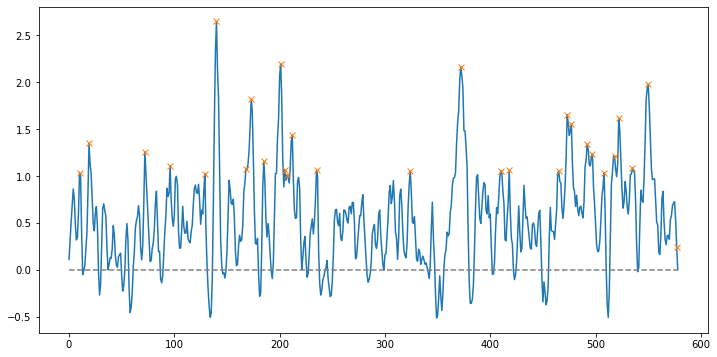

Peak count: 29
Frame tokens: 100% 2-0 Glanford Chesterfield lead, goal, Uniteds Peterboroughs Clough’s finalists Chesterfield, League 1-0 only Doncaster’s Matt helped victory. Hourihane 2-1 Colchester Wilsons Oldham Yeovil Dawson winner. lead. goal. net. 

Similarity : 0.4884629178798321
Train... |||||||||||||||||||||| 100.0%   200/200 epochs, Generator / grammar loss:-0.1911308467388153   similarity loss:-0.28146252036094666


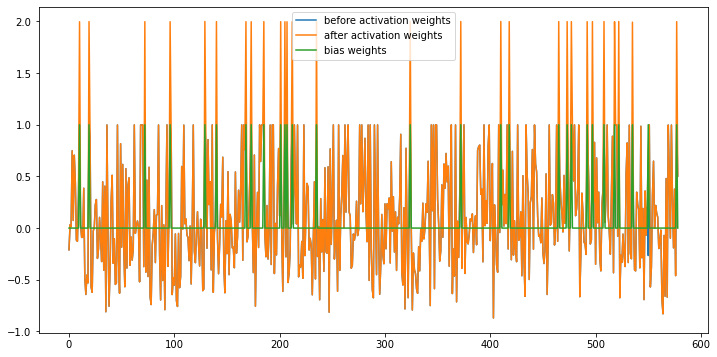

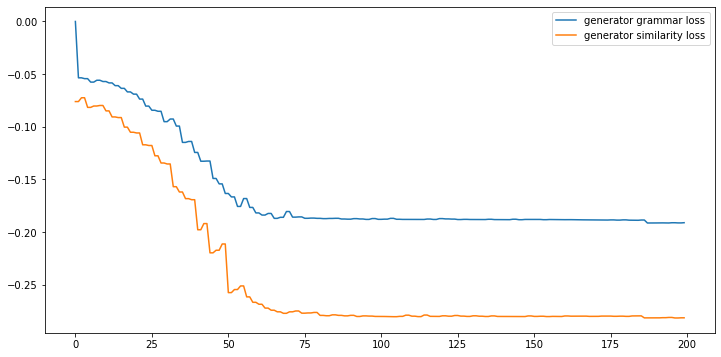

--------------------------------------------------
gold summary:
Fleetwood top of League One after 2-0 win at Scunthorpe .
Peterborough, Bristol City, Chesterfield and Crawley all drop first points of the season .
Stand-in striker Matt Done scores a hat-trick as Rochdale thrash Crewe 5-2 .
Wins for Notts County and Yeovil .
Coventry/Bradford and Oldham/Port Vale both end in draws .
A late Stephen Bywater own goal denies Gillingham three points against Millwall .
--------------------------------------------------
sam_wgan summary:
100% 2-0 in history with scoring the goals Glanford of Peterborough, Chesterfield 2-1 their lead, out goal, for battle: Uniteds Peterboroughs City, beat Nigel Clough’s were to a finalists Chesterfield, League 1-0 MK play One only Bradford a James the minutes Joe Heads Bristol (left) Orients Doncaster’s 1-1 which them down but a Matt a Railwaymen but Peter helped big victory. and all Josh Tykes from Hourihane 2-1 Colchester with Murray on Wilsons Oldham Yeovil 

,method,comp ratio,intro,body,ending,var,total,grammar,R1,R2,RL
0,SAM+WGAN,0.156113,0.494068,0.542552,0.563902,0.000854,0.538833,0.976238,0.308642,0.012500,0.148148
1,BERT+LexRank,0.146484,0.555006,0.495840,0.503934,0.000686,0.509939,0.998460,0.289474,0.106667,0.157895
2,BESM,0.156405,0.614685,0.555573,0.547481,0.000897,0.565130,0.991295,0.254545,0.073620,0.157576
3,BESM+kobert,0.156405,0.614685,0.555573,0.547481,0.000897,0.565130,0.991295,0.254545,0.073620,0.157576
4,transformer,0.112051,0.550019,0.479444,0.424950,0.002621,0.478301,0.943123,0.310078,0.110236,0.217054
5,T5,0.115261,0.742789,0.382750,0.326898,0.033968,0.439119,0.989986,0.291971,0.103704,0.204380


In [49]:
df1,_ = sam_wgan(g_summ,[org_text_1,org_text_2,org_text_3],display= True)
df2,_ = bert_lexrank_sum(g_summ,[org_text_1,org_text_2,org_text_3])
df3,_ = besm(g_summ,[org_text_1,org_text_2,org_text_3])
df4,_ = besm_bert(g_summ,[org_text_1,org_text_2,org_text_3])
df5,_ = abstract_method_1(g_summ,[org_text_1,org_text_2,org_text_3])
df6,_ = abstract_method_2(g_summ,[org_text_1,org_text_2,org_text_3])
result = pd.concat([df1, df2, df3, df4, df5, df6], ignore_index=True)
#result = pd.concat([df1, df2, df3, df5, df6], ignore_index=True)
result


In [79]:
import sys

def get_features(dct1):
    return [dct1['comp ratio'][0],dct1['intro'][0],dct1['body'][0],dct1['ending'][0],dct1['var'][0],dct1['total'][0],dct1['grammar'][0],dct1['R1'][0],dct1['R2'][0],dct1['RL'][0]]

test_result = {}
test_result['SAM+WGAN']=[]
test_result['BERT+LexRank']=[]
test_result['BESM']=[]
test_result['BESM+kobert']=[]
test_result['Transformer']=[]
test_result['T5']=[]

In [80]:
def get_test_statistics(test_result):
    df_data = {}
    df_data['method'] = []
    df_data['comp rate'] = []
    df_data['intro'] = []
    df_data['body'] = []
    df_data['conclusion'] = []
    df_data['isthmus'] = []
    df_data['simlirality'] = []
    df_data['grammarity'] = []
    df_data['R1'] = []
    df_data['R2'] = []
    df_data['RL'] = []
    for key in test_result:
        df_data['method'].append(key)
        data = np.asarray(test_result[key])
        df_data['comp rate'].append(np.mean(data[:,0]))
        df_data['intro'].append(np.mean(data[:,1]))
        df_data['body'].append(np.mean(data[:,2]))
        df_data['conclusion'].append(np.mean(data[:,3]))
        df_data['isthmus'].append(np.mean(data[:,4]))
        df_data['simlirality'].append(np.mean(data[:,5]))
        df_data['grammarity'].append(np.mean(data[:,6]))
        df_data['R1'].append(np.mean(data[:,7]))
        df_data['R2'].append(np.mean(data[:,8]))
        df_data['RL'].append(np.mean(data[:,9]))

    df = pd.DataFrame(df_data)
    return df

In [83]:
def prepare_data(offset,length):
    document = []
    for i,doc in zip(range(offset,offset+length),sentences_dataset[offset:offset+length]):
        intro,body,end = clear_article(doc)
        document.append([gold_summary[i],intro,body,end])

    return document


document = prepare_data(20,30)


In [ ]:
document[5]

In [82]:

step = 0
for g_summ,intro,body,end in document:
    step += 1
    print("=" * 50)
    print(str(step),"/",len(document))
    print("=" * 50)
    
    org_text_1 = intro
    org_text_2 = body
    org_text_3 = end

    try:
        df1,dct1 = sam_wgan(g_summ,[org_text_1,org_text_2,org_text_3])
        df2,dct2 = bert_lexrank_sum(g_summ,[org_text_1,org_text_2,org_text_3])
        df3,dct3 = besm(g_summ,[org_text_1,org_text_2,org_text_3])
        df4,dct4 = besm_bert(g_summ,[org_text_1,org_text_2,org_text_3])
        df5,dct5 = abstract_method_1(g_summ,[org_text_1,org_text_2,org_text_3])
        df6,dct6 = abstract_method_2(g_summ,[org_text_1,org_text_2,org_text_3])

        test_result['SAM+WGAN'].append(get_features(dct1))
        test_result['BERT+LexRank'].append(get_features(dct2))
        test_result['BESM'].append(get_features(dct3))
        test_result['BESM+kobert'].append(get_features(dct4))
        test_result['Transformer'].append(get_features(dct5))
        test_result['T5'].append(get_features(dct6))
        result = pd.concat([df1, df2, df3, df4, df5, df6 ], ignore_index=True)
        #result = pd.concat([df1, df2, df3, df5, df6 ], ignore_index=True)
        
        print(result)
        
        print("Current result","=" * 50)
        print("Sample count:",len(test_result['SAM+WGAN']))
        print(get_test_statistics(test_result))
        
    except KeyboardInterrupt as ki:
        raise ki
    except:
        print("Unexpected error:", sys.exc_info()[0])
        pass

get_test_statistics(test_result)

1 / 20
------------------------------------------------------------------
The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A. State Immunization Program Manager Molly Howell says the risk is low, but officials feel its important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained bishops in Italy last month. Symptoms o

Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0] 1/393        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1] 1/392        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2] 1/391        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2, 3] 1/390        
Negative tokens: ['Mata' 'Police' 'investigates' 'authorities' 'trafficking' 'criminal'
 'Court' 'accuses' 'using' 'police' 'trafficking' 'gifts,' 'assassins'
 'cops,' 'shooting' 'according' 'plot,' 'payment' 'setting' 'prosecutors'
 'complaint' 'police' 'complaint,' 'weapons' 'luggage' 'Miami' 'Court'
 'trafficking' 'narcotics' 'Ecuador' 'Republic' 'shipping' 'narcotics'
 'arrested' 'Miami' 'attorney,' 'Mata' 'Police' 'investigations' 'working'
 'Miami' 'working' 'cocaine,' 'cocaine' 'property' 'scheduled' 'Florida'
 'convicted,']
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1] 391/392       
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2] 390/

Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0] 1/807        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1] 1/806        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2] 1/805        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2, 3] 1/804        
Negative tokens: ['crash' 'phone' 'Eccleston-Todd,' 'driving' 'night' 'pub' 'reading'
 'veered' 'driving' 'car' 'crashed' 'car' 'driven' 'died' 'crash' 'car'
 'drunk' 'guilty' 'dangerous' 'Miss' 'solicitor’s' 'friends' 'pub'
 'alcohol,' 'driving' 'collision’,' 'driving' 'tragic' 'Titley,' 'death'
 'driving' 'distracted' 'crossing' 'wreckage' 'her\xa0Daihatsu' 'died'
 'injuries' '‘Miss' 'She' 'evening' 'friends' 'driving' 'friends' '‘Miss'
 'danger' 'Eccleston-Todd' 'accident' 'drink-drive' 'police' 'over'
 'phone' 'texting' 'collision' 'family' 'friends' 'pub' 'collision'
 'sadly' 'Eccleston-Todd' 'met' 'friends' 'pub' 'drank' 'pub' 'collision'
 'blood' 'collision' 'limit,' 'ov

Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0] 1/528        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1] 1/527        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2] 1/526        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2, 3] 1/525        
Negative tokens: ['breezy' 'Putin' 'turbulent' 'Russian' 'Ukraines' 'blatant' 'grab'
 'eastern' 'quick' 'Europes' 'Crimeas' 'restrictions' 'politicians'
 'Europe' 'Russian' 'logic' 'Russia' 'Alexei' 'Moscow' 'opposing'
 'Europes' 'Putins' 'Abramovich' 'money' 'freezes' 'restrictions' 'EU'
 'cumbersome' 'Russia' 'Hermitage' 'Moscow-based' 'Russia' 'orphans'
 'retaliation' 'anti-corruption' 'Magnitsky,' 'Moscow' 'Yet' 'money'
 'Europe' 'consequences' 'EU' 'sanctions' 'hurt' 'Russias' 'tenuous'
 'strategy' 'EU' 'deal' 'unpleasant' 'money' 'prize' 'Europe'
 'post-Soviet' 'commerce' 'lot' 'Russia' 'EU' 'exports' 'Europe' 'hefty'
 'Russian' 'hard' 'factories' 'Putin' 'trade' 'change'

Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0] 1/578        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1] 1/577        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2] 1/576        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2, 3] 1/575        
Negative tokens: ['League' 'win' 'third' 'history' 'scoring' 'goals' 'won' 'Bristol' '2-1'
 'Sheffield' 'Baxter’s' 'first-half' 'winner' 'Baxter' 'scoring'
 'Sheffield' 'Sheffield' 'keenly-contested' 'Bristol' 'beat' 'goalless'
 'champions,' 'Manchester' 'loanee' 'scored' 'game' 'unbeaten' 'Bradford'
 'win' 'score' 'season' 'equalised' 'Bristol' 'Leyton' 'Mason' 'win'
 'Bradford' 'second' 'equaliser' 'Joe' 'contract' 'Tuesday,' '1-1'
 'Humphrey' 'secured' 'high-scoring' 'Crewe' 'Haber' 'treble' 'goals'
 'goals' 'Coventry' '2-2' 'goals' 'McQuoid' 'lead,' 'Tykes' 'win' 'Noble'
 'equaliser' 'Vale' 'Tom' '2-1' 'victory' 'equalised' 'Gillingham' '2-2'
 'lead' 'Swindon' 'Brancos']
Fr

Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0] 1/300        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1] 1/299        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2] 1/298        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2, 3] 1/297        
Negative tokens: ['fashion' 'Lanzarote' 'family,' 'shoes' 'beige' 'Teguise' 'fashion'
 'Cameron' 'husband' 'elegant' 'dress' 'Arthur' 'smart' 'shoes' 'holiday'
 'styled' 'and' 'ideal' 'reputedly' 'Cameron' 'attire,' 'wearing' 'shoes'
 'socks' 'Refreshment:' 'coffee' 'Camerons']
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1] 298/299       
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2] 297/298       
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2, 3] 296/297       
Peak count: 16
Frame tokens: David pair he Mr David yesterday. shoes. loafers. cardigan. wear has David Lanzarote. holidayed Lanzarote, Island. 

Similarity : 0.392

Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0] 1/637        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1] 1/636        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2] 1/635        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2, 3] 1/634        
Negative tokens: ['HIV,' 'surprised' 'news' 'HIV' 'helped' 'HIV/Aids' 'more' 'disease,'
 'dedicated' 'HIV' 'We' 'important' 'doctor' 'HIV' 'scared' 'NBA'
 'treatment' 'Dr' 'HIV' 'Aids' 'helped' 'diagnosis,' 'influenced'
 'playing' 'HIV' 'He' 'HIV' 'Aids,' 'questions' 'wife' 'pregnant' 'she'
 'disease,' 'help' 'other' 'HIV' 'us,' 'dying' 'people' 'know' 'disease,'
 'HIV' 'HIV' 'awareness' 'disease' '12' 'population,' 'They' 'Hispanic'
 'HIV' 'Disease' 'Prevention,' 'HIV,' 'Support:' 'pregnant' 'vital' 'Aids'
 'raising' 'needs' 'awareness' 'HIV' 'Aids']
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1] 635/636       
Frame token scan: |||||||||||||||||||||| 100.0%   

Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0] 1/607        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1] 1/606        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2] 1/605        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2, 3] 1/604        
Negative tokens: ['This' 'beware' 'service' 'pulling' 'Telford' 'comments' 'recording'
 'announcer' 'heard' 'Telford' 'aware' 'beware' 'remark' 'greeted'
 'cheers' 'Wolverhampton' 'But' 'Midland' 'investigation' 'incident' 'his'
 'Bayston' 'Shropshire,' 'banter' 'threatened' 'hostile' 'helped'
 'trouble' 'shame' 'Shrewsbury' 'Welcome' 'civilisation' 'train' 'train'
 'humour' 'comments' 'disgust' 'offensive' 'Telford' 'hearing'
 'derogatory' 'offend' 'we' 'thieves,' 'professional' 'insulting'
 'investigation' 'incident' 'Shrewsbury' 'humour' 'funny' 'unprofessional'
 'travelling' 'derby' 'He' 'Tensions' 'match' 'helped' 'service' 'pulling'
 'Telford' 'comments' 'Telford' 'nice' 

Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0] 1/589        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1] 1/588        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2] 1/587        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2, 3] 1/586        
Negative tokens: ['waiting' 'Fletcher' 'he' 'expected' 'Fletcher’s' 'signing' 'almost'
 'himself' 'Fletcher' 'mentor' 'player' 'bigger' 'advised' 'his' 'role'
 'he' 'come' 'coach' 'believes' 'Fletcher,' 'Having' 'Sir' 'he' 'deal'
 'Fletcher' 'players' 'impressive' 'he' 'he' 'he' 'hat-trick' 'mentors'
 'lads' 'need' 'mentors' 'respect' 'critical' 'him' 'worked' 'him'
 'captain' 'he' 'joked' 'great' 'Fletcher' 'he' 'ideal' 'play' 'work' 'He'
 'talking' 'Fletcher' 'impressed' 'training' 'lads' 'loves' 'He’s'
 'player' 'players' 'he' 'he' 'He’s' 'influence']
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1] 587/588       
Frame token scan: |||||||||||||||||||||| 100.0%

Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0] 1/870        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1] 1/869        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2] 1/868        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2, 3] 1/867        
Negative tokens: ['Australia' 'Hidden' 'Australian' 'science' 'computer' 'microscope'
 'happens' 'room' 'inside' 'Malaysian' 'recovered' 'place' 'critical'
 'solving' 'happened' 'Boeing' 'engineer' 'data' 'Campbell' 'thrives'
 'technical' 'attracts' 'can' 'rewarding,' 'handful' 'Malaysians,'
 'international' 'charge' 'investigation' 'Australia' 'devices' 'data'
 'cockpit' 'recorder' 'surface' 'packed' 'bin' 'solidifying' 'memory'
 'recorder' 'lab,' 'rinse' 'process' 'data' 'work' 'download' 'memory'
 'open' 'process' 'technical' 'recorders' 'labs' 'boxes' 'bright'
 'exterior' 'recorders,' 'tackle' 'only' 'investigators' 'Survivable'
 'gloves' 'anti-static' 'peeling' 'protective

Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0] 1/1332         
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1] 1/1331         
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2] 1/1330         
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2, 3] 1/1329         
Negative tokens: ['map' 'North' 'larger' 'larger' 'China' 'map' '1596' 'map' '1596' 'map'
 'land' 'distorting' 'sizes' 'lands' 'advent' 'imagery' 'maps' 'world,'
 'necessarily' 'Much' 'technical' 'assumptions' 'way' 'reality'
 'spherical' 'map' 'cartographers' 'best' 'Mercator' 'poles' 'world'
 'Columbus' 'map' 'support' 'map' 'cartographer' 'theories' 'world'
 'accurate' 'map' 'larger' 'map' 'Scandinavian' 'larger' 'size'
 'Scandinavian' 'map,' 'large' 'larger' 'maps' 'diverse,' 'familiar'
 'shapes' 'land' 'distorting' 'sizes' 'lands' 'north' 'big,' 'larger,'
 'Greenland' 'comparable' 'larger' 'north' 'space' 'Greenland,'
 'continent' 'equal' 'land' 'map' 'Scandinavian

Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0] 1/584        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1] 1/583        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2] 1/582        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2, 3] 1/581        
Negative tokens: ['claims' 'Dershowitz' 'lawsuit' 'accusing' 'court' 'court' 'Edwards'
 'Palace' 'Dershowitz' 'lawyers' 'Dershowitz,' 'counter-defamation'
 'Dershowitz,' 'defamation' 'lawyers' 'urged' 'sworn' 'court,' 'Epsteins'
 'allegations' 'lawsuit,' 'accused' 'Dershowitz,' 'defamation' 'Edwards'
 'urged' 'Controversy:' 'accused' 'Dershowitz' 'sued' 'prove' 'story'
 'Dershowitz' 'court' 'accusers' 'father,' 'accused' 'Dershowitz'
 'Epsteins' 'Dershowitz' 'lawsuit' 'accuser' 'abused' 'charges' 'charges,']
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1] 582/583       
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2] 581/582       
Frame token s

Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0] 1/967        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1] 1/966        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2] 1/965        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2, 3] 1/964        
Negative tokens: ['pet' 'they' 'faithful' 'pet' 'owner' 'Joy' 'pets' 'live' 'embrace:'
 'just' 'professional' 'Joy' 'She' 'love' 'service' 'popular'
 'photographers' 'pets' 'animals' 'definitely' 'happy' 'owners' 'favorite'
 'she' 'Mrs' 'Joy' 'share' 'Mrs' 'Joy' 'owner' 'beautiful,' 'highlight'
 'relationship' 'pet' 'photo' 'friend' 'gift,' 'we' 'beautiful'
 'companionship' 'saved' 'She' 'low,' 'Joy' 'her' 'knowing' 'much' 'but'
 'happy' 'professional' 'service' 'enough' 'Mrs' 'photographers' 'pets'
 'blessed' 'Joy' 'Joy' 'wonderful' 'easy' 'Joy' 'She' 'Joy' 'We' 'chatted'
 'zest' 'health,' 'fresh' 'helped' 'meaningful' 'pet' 'pet' 'knowing'
 'Joy' 'offer' 'pets' 'pets' 'want' 

Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1] 408/409       
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2] 407/408       
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2, 3] 406/407       
Peak count: 21
Frame tokens: McNair Uniteds him McNair Southampton. Southampton. victory. match, (McNair) He big win. ensured three slices ball scored goal McNair celebrates opener. 

Similarity : 0.41145439709719267
Train... |||||||||||||||||||||| 100.0%   200/200 epochs, Generator / grammar loss:-0.1976340264081955   similarity loss:-0.20565925538539886
--------------------------------------------------
gold summary:
Manchester United beat Southampton 2-1 at St Mary's on Monday night .
Paddy McNair was substituted by Louis van Gaal after only 39 minutes .
Van Gaal admitted he 'had to' replace the 19-year-old against Saints .
United boss said McNair 'had no confidence' after struggling early on .
But Van Gaal is adamant substitution was 'in best 

Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0] 1/776        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1] 1/775        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2] 1/774        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2, 3] 1/773        
Negative tokens: ['(CNN)' 'learning' 'corporation' 'corporate-speak' 'company'
 'exponentially' 'corporate' 'Walgreen,' 'merging' 'companies' 'claim'
 'taxes,' 'corporations' 'headquarters,' 'change' 'buying' 'merger'
 'company' 'operational' 'Minneapolis,' 'company' 'company' 'taxes' 'firm'
 'taxes;' 'Congress' 'law' 'tax' 'largest' 'Inversions' 'corporations'
 'Research' 'corporate' 'revenue' 'corporations' 'profits' 'corporations'
 'IRS' 'profits' 'profits' 'exponentially' 'economy,' 'companies'
 'accounting' 'corporations' 'tricks' 'taxes' 'earnings' 'profits'
 'Corporations' 'invert' 'profits' 'Corporate' 'earnings' 'profits'
 'exposÃ©' 'profitable' 'profits' 'corporation'

Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0] 1/470        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1] 1/469        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2] 1/468        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2, 3] 1/467        
Negative tokens: ['holiday' 'home,' 'detox' 'free' 'home' 'Resort,' 'spa' 'Park' 'Holidays'
 'smartphone' 'enjoy' 'luxury;' 'temptation' 'holiday' 'unplug,'
 'spending' 'mobile' 'e-mails' 'access' 'social' 'website' 'free'
 'customers' 'website' 'devices,' 'hotels' 'holidays' 'Spa,' 'tech-free'
 'enable' 'peace' 'Recognized' 'retreat' 'you’ve' 'Lodge' 'winter'
 'visiting' 'holiday' 'smartphone' 'Locations' 'marketed' 'Spa' 'Monaco'
 'guests' 'devices' 'luxury' 'picturesque' 'Spa,' 'holiday' 'take'
 'unwind,' 'beach' 'snowboarding' 'check' 'benefit' 'e-mails' 'work/life']
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1] 468/469       
Frame token scan: ||||||||||||

Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0] 1/627        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1] 1/626        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2] 1/625        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2, 3] 1/624        
Negative tokens: ['Dencia' 'her' 'white' 'tweet' 'she' 'creams' 'her!!' 'Dencia' 'her'
 'cream' 'value' 'Dencia' 'her' 'white' 'she' 'creams' 'her!!'
 'controversy;' 'Whitenicious' 'skin-lightener,' 'cure' 'Dencia' 'telling'
 'she' 'hypocritical' 'surprise' 'Miss' 'Women' 'Influential:' 'Miss'
 'fan' 'skin-whitening' 'actress' 'love' 'Miss' 'beauty' 'her' 'girl'
 'her' 'successful' 'Whitenicious' 'actress' 'wake' 'Hypocritical:'
 'controversy;' 'Whitenicious' 'skin-lightener,' 'cure' 'take' 'Dencia'
 'she' 'buy' 'actress' 'Dencia' 'tweet' 'Miss' 'lupita' 'WINS!!' 'Dencia'
 'cosmetics' 'cream' 'cosmetics,' 'brighteners' 'melanin' 'Dencias'
 'white' 'skin']
Frame token scan: ||||

Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0] 1/1452         
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1] 1/1451         
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2] 1/1450         
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2, 3] 1/1449         
Negative tokens: ['jihadists' 'urged' 'more' 'fight' '‘spoil' 'British' 'jihadis' 'Abdul'
 'earlier' 'Britons' 'RAF,' 'Lambert,' 'defence' 'Britain' 'gruesome'
 'jihadist,' 'murdering' 'revenge' '‘brutal' 'British' 'Baghdad' 'Iraqi'
 'RAF\xa0' '‘listening' 'chatter' 'Tornado' 'surveillance' 'targets\xa0'
 'vast' 'crucial' 'militants’' 'efforts' 'bombers' 'missions' '1992'
 'warned' 'jihadists' 'pounded' 'murder,' 'more' 'fanatical,' 'long'
 'Marshal' 'RAF,' 'Lambert,' 'defence' 'Britain' 'jihadist,' 'revenge'
 'West' 'jihadists' 'artillery' 'army,' 'We' 'arming' 'up' 'playing'
 'more' 'troubled' 'building' 'Forces' 'inflict' 'closely' 'Peshmerga,'
 'jihadists' 'area]' '

Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0] 1/395        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1] 1/394        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2] 1/393        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2, 3] 1/392        
Negative tokens: ['charged' 'manslaughter' 'boyfriends' 'fighting' 'Angelina' 'assaulted'
 'victim' 'Prosecutor' 'boyfriend' 'Injured:' 'scratches' 'fight,'
 'prosecutor,' 'relationship' 'Police' 'Monday' 'trauma' 'victim,'
 'injury' 'assault,' 'prosecutor' 'Hernandez' 'scratches' 'interviewed,'
 'assaulted' 'suffered' 'arrest' 'police' 'Examiners' 'autopsy'
 'toxicology' 'prosecutor' 'charged' 'manslaughter,' 'violence'
 'apprehension,' 'investigators' 'crime' 'Jail' 'charged' 'endangerment'
 'violence' 'court' 'Hackensack']
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1] 393/394       
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2] 392/393   

Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0] 1/329        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1] 1/328        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2] 1/327        
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2, 3] 1/326        
Negative tokens: ['Syria' 'refugee' 'Lebanon' 'Syrians' 'Lebanese' 'Syrian' 'Syrian'
 'Bekaa' 'News' 'casualties' 'Hospital' 'Syrian' 'rebels' 'supplies'
 'Syrian' 'spokeswoman' 'Lebanon' 'Syrian' 'concern' 'cross-border'
 'Lebanese' 'Lebanese-Syrian' 'Syria' 'Syrians' 'Lebanon,' 'million'
 'Lebanese' '1' 'true' 'influx' 'Syrian' 'unrest,' 'al-Assad' 'evolved'
 'war' 'refugees,' 'Syria' 'Beirut,' 'Hamdi']
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1] 327/328       
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2] 326/327       
Frame token scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2, 3] 325/326       
Peak count: 17
Frame tokens: out a

,method,comp rate,intro,body,conclusion,isthmus,simlirality,grammarity,R1,R2,RL
0,SAM+WGAN,0.165885,0.459931,0.438485,0.445563,0.001792,0.444178,0.931901,0.285755,0.022769,0.159589
1,BERT+LexRank,0.173811,0.312839,0.309350,0.290787,0.002586,0.308936,0.968884,0.217736,0.043599,0.123624
2,BESM,0.200749,0.628581,0.460335,0.438879,0.013483,0.493573,0.984613,0.310761,0.100494,0.187474
3,BESM+kobert,0.210101,0.613403,0.460204,0.437944,0.010062,0.486760,0.988586,0.346385,0.135556,0.201760
4,Transformer,0.146585,0.553718,0.436189,0.361316,0.010824,0.441475,0.972643,0.408262,0.210352,0.284802
5,T5,0.118442,0.564194,0.404639,0.333538,0.018270,0.418130,0.956277,0.408594,0.181516,0.268367


## Reference

[1] Rada Mihalcea and Paul Tarau, (2004). TextRank: Bringing Order into Texts <br>
[2] G¨une¸s Erkan. (2004). LexRank: Graph-based Lexical Centrality as Salience in Text Summarization <br>
[3] Susan T. Dumais (2005). "Latent Semantic Analysis". Annual Review of Information Science and Technology. 38: 188–230. <br>
[4] Hans Peter Luhn (1960). Keyword-in-context index for technical literature. American Documentation, 11(4):288–295. ISSN 0002-823 <br>
[5] Aria Haghighi, (2009). Exploring Content Models for Multi-Document Summarization <br>
[6] Colin Raffel. (2020). Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer <br>
[7] Mike Lewis, (2019). BART: Denoising Sequence-to-Sequence Pre-training for Natural Language Generation, Translation, and Comprehension <br>
[8] Alec Radford, (2018). Language Models are Unsupervised Multitask Learners <br>
[9] Guillaume Lample, (2019). Cross-lingual Language Model Pretraining <br>
[10] Nils Reimers and Iryna Gurevych, (2019). Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks <br>
[11] Sharma, P., & Li, Y. (2019). Self-Supervised Contextual Keyword and Keyphrase Retrieval with Self-Labelling <br>
[12] Jacob Devlin, (2019). BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding <br>
[13] Ian J. Goodfellow, (2014). Generative Adversarial Nets <br>
[14] Yau-ShianWang, (2018). Learning to Encode Text as Human-Readable Summaries using Generative Adversarial Networks <br>
[15] Martin Arjovsky, (2017). Wasserstein GAN <br>